<a href="https://colab.research.google.com/github/emilia-uncc/IntroML/blob/main/assignment5/Assignment5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable


#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
file_path = '/content/drive/My Drive/DataSets/Housing.csv'
housing = pd.DataFrame(pd.read_csv(file_path))
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [33]:
housing.isnull().sum()*100/housing.shape[0]

price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64

In [34]:
varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [35]:
## Generate a list of integer positions for the columns you want to select
#area, bedrooms, bathrooms, stories, parking
#selected_columns_indices = [i for i in range(2,32)]  # Selects the first 30 columns
selected_columns_indices = [1, 2, 3, 4, 10]
print(selected_columns_indices)
X = housing.iloc[:, selected_columns_indices].values
#M = 1, E = 0
Y = housing.iloc[:, 0].values
#print(X)
#print(Y)

[1, 2, 3, 4, 10]


In [36]:
np.random.seed(0)
#df_train = training set, #df_test = testset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [37]:
#scale dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train)

[[-0.71677205 -1.29437561 -0.57330726 -0.93314164 -0.81914879]
 [-0.53893631 -1.29437561 -0.57330726 -0.93314164 -0.81914879]
 [-0.98820554 -1.29437561 -0.57330726 -0.93314164 -0.81914879]
 ...
 [ 0.28004406  0.05251643  1.4755613   2.50502532  0.32555914]
 [-0.72613182  0.05251643 -0.57330726 -0.93314164  0.32555914]
 [ 0.67783452  0.05251643 -0.57330726 -0.93314164 -0.81914879]]


In [38]:
#------------------functions general-----------------------------------------



# Define a custom loss function (mean squared error)
def loss_fn(y_pred, target):
    return torch.mean((y_pred - target) ** 2)

#------------------functions linear model-------------------------------------
# Define a custom multi-dimensional linear model as a tensor
def multi_linear_model(input_size, output_size):
    weights = torch.rand(output_size, input_size, dtype=torch.float32) * 0.1  # Initialize weights with small random values
    weights.requires_grad = True  # Enable gradient tracking
    return weights
    #return torch.zeros((output_size, input_size), dtype=torch.float32, requires_grad=True)

#SGD and Adam
def training_loop_linear(n_epochs, optimizer, params, t_u, t_c):
  for epoch in range(1, n_epochs +1):
    t_p = model(t_u, *params) #calc output
    loss = loss_fn(t_p, t_c) #calc loss

    optimizer.zero_grad() # zero the gradients
    loss.backward() #calc gradients of the params
    optimizer.step() #calc the gradients

    if epoch % 500 == 0:
      print(f"Epoch: {epoch}, Loss: {float(loss)}")
      #print('Epoch %d, Loss %f' % (epoch, float(loss)))

  return params

# Define your training loop
def training_loop(n_epochs, optimizer, weights, inputs, targets, test_set, test_target):
    losses = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):

        predictions = torch.matmul(inputs, weights.t())
        loss = loss_fn(predictions, targets)
        pred_test = torch.matmul(test_set, weights.t())
        loss_test = loss_fn(pred_test, test_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(weights)
            print(f"Epoch: {epoch}, Loss: {loss.item()}, val_loss: {loss_test.item()}")
            losses.append(loss.item())
            val_losses.append(loss_test.item())

        if epoch % 20 == 0:
            losses.append(loss.item())
            val_losses.append(loss_test.item())


    return weights, losses, val_losses


In [39]:
#arrays into tensors
X_train_tensor = 0.01 * torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = 0.01 *torch.tensor(X_test, dtype=torch.float32)

Y_train_tensor = 0.01 * torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = 0.01 *torch.tensor(Y_test, dtype=torch.float32)

# Example usage with multi-dimensional input data:
input_size = 5  # Change this to the number of input features
output_size = 1  # Output size is 1 for regression

weights = multi_linear_model(input_size, output_size)
#optimizer = optim.SGD([weights], lr=0.0001)
n_epochs = 5000
optimizer = optim.Adam([weights], lr = 0.1)

weights, losses, val_losses = training_loop(n_epochs, optimizer, weights, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor)

test_predictions = torch.matmul(X_test_tensor, weights.t())
#print(test_predictions)
print(weights)
print(losses)
print(val_losses)
#630995459954

tensor([[ 0.0387,  0.2205, -0.5554,  0.0680, -0.2060]], requires_grad=True)
Epoch: 500, Loss: 2646998016.0, val_loss: 2518924288.0
tensor([[ 0.0507,  0.1912, -0.5586,  0.1125, -0.2241]], requires_grad=True)
Epoch: 1000, Loss: 2646998016.0, val_loss: 2518924288.0
tensor([[ 0.0351,  0.2130, -0.5433,  0.0833, -0.2025]], requires_grad=True)
Epoch: 1500, Loss: 2646998016.0, val_loss: 2518924288.0
tensor([[ 0.0396,  0.2053, -0.5647,  0.0963, -0.2093]], requires_grad=True)
Epoch: 2000, Loss: 2646998016.0, val_loss: 2518924288.0
tensor([[ 0.0655,  0.2308, -0.5765,  0.1048, -0.2148]], requires_grad=True)
Epoch: 2500, Loss: 2646997760.0, val_loss: 2518924288.0
tensor([[ 0.0523,  0.1751, -0.5791,  0.0773, -0.1489]], requires_grad=True)
Epoch: 3000, Loss: 2646998016.0, val_loss: 2518924288.0
tensor([[ 0.0834,  0.2521, -0.5764,  0.0600, -0.2432]], requires_grad=True)
Epoch: 3500, Loss: 2646998016.0, val_loss: 2518924288.0
tensor([[ 0.0661,  0.2471, -0.5397,  0.0564, -0.2230]], requires_grad=True)
E

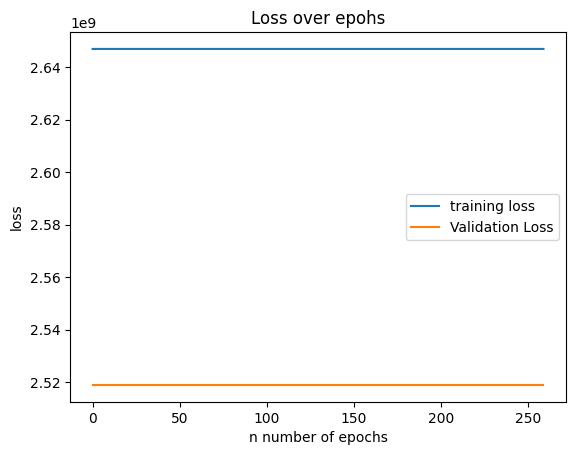

In [40]:
# 4. Plot the training and validation loss after each iteration
plt.plot(losses, label="training loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("n number of epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Loss over epohs")
plt.show()

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim


# Define your model as a class
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define a function for training your model
def train_model(model, X_train, Y_train, X_test, Y_test, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Forward pass and loss calculation for the test set
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, Y_test)

        # Calculate and save the loss
        if (epoch + 1) % 500 == 0:
            losses.append(loss.item())
            test_losses.append(test_loss.item())
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, {test_loss.item():.4f} ')

    return losses, test_losses

# Example usage
criterion = nn.MSELoss()
input_size = 5
hidden_size = 10
output_size = 1
model = MyModel(input_size, hidden_size, output_size)

X_train_tensor_n  = 0.001 * X_train_tensor
X_test_tensor_n = 0.001 * X_test_tensor

Y_train_tensor_n = 0.001 * Y_train_tensor
Y_test_tensor_n = 0.001 * Y_test_tensor

num_epochs = 5000
learning_rate = 0.000001

# Train the model using your data tensors
losses, test_losses = train_model(model, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, num_epochs, learning_rate)

# Calculate the final test loss
with torch.no_grad():
    test_outputs = model(X_test_tensor_n)
    test_loss = criterion(test_outputs, Y_test_tensor_n)
print(f'Final Test Loss: {test_loss.item():.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([436])) that is different to the input size (torch.Size([436, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([109])) that is different to the input size (torch.Size([109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [500/5000], Loss: 364418208.0000, 288448960.0000 
Epoch [1000/5000], Loss: 364418208.0000, 288448992.0000 
Epoch [1500/5000], Loss: 364418208.0000, 288448960.0000 
Epoch [2000/5000], Loss: 364418208.0000, 288448960.0000 
Epoch [2500/5000], Loss: 364418208.0000, 288448992.0000 
Epoch [3000/5000], Loss: 364418208.0000, 288448960.0000 
Epoch [3500/5000], Loss: 364418208.0000, 288448992.0000 
Epoch [4000/5000], Loss: 364418208.0000, 288448960.0000 
Epoch [4500/5000], Loss: 364418208.0000, 288448960.0000 
Epoch [5000/5000], Loss: 364418208.0000, 288448960.0000 
Final Test Loss: 2278067712.0000


In [47]:
import torch
from torch.autograd import Variable
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

inputDim = 5       # takes variable 'x'
outputDim = 1       # takes variable 'y'
learningRate = 0.1
epochs = 5000


model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

test_losses = []
losses = []

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(X_train_tensor).cuda())
        labels = Variable(torch.from_numpy(Y_train_tensor).cuda())
    else:
        inputs = Variable(X_train_tensor)
        labels = Variable(Y_train_tensor)
        inputs_val = Variable(X_test_tensor)
        labels_val = Variable(Y_test_tensor)

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)

    # Forward pass and loss calculation for the test set
    with torch.no_grad():
        val_pred = model(inputs_val)
        test_loss = criterion(val_pred, Y_test_tensor)

    #print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    if epoch % 500 == 0:
            #print(weights)
            print(f"Epoch: {epoch}, Loss: {loss.item()}, val_loss: {test_loss.item()}")
            #losses.append(loss.item())
            #val_losses.append(test_loss.item())


    losses.append(loss.item())
    val_losses.append(test_loss.item())

    #print('epoch {}, loss {}'.format(epoch, loss.item()))

Epoch: 0, Loss: 2647018240.0, val_loss: 2518944000.0
Epoch: 500, Loss: 2642243584.0, val_loss: 2514224384.0
Epoch: 1000, Loss: 2637477120.0, val_loss: 2509512192.0
Epoch: 1500, Loss: 2632716800.0, val_loss: 2504806400.0
Epoch: 2000, Loss: 2627962624.0, val_loss: 2500106496.0
Epoch: 2500, Loss: 2623215104.0, val_loss: 2495413248.0
Epoch: 3000, Loss: 2618472704.0, val_loss: 2490725632.0
Epoch: 3500, Loss: 2613735936.0, val_loss: 2486043392.0
Epoch: 4000, Loss: 2609004544.0, val_loss: 2481366272.0
Epoch: 4500, Loss: 2604279040.0, val_loss: 2476695296.0


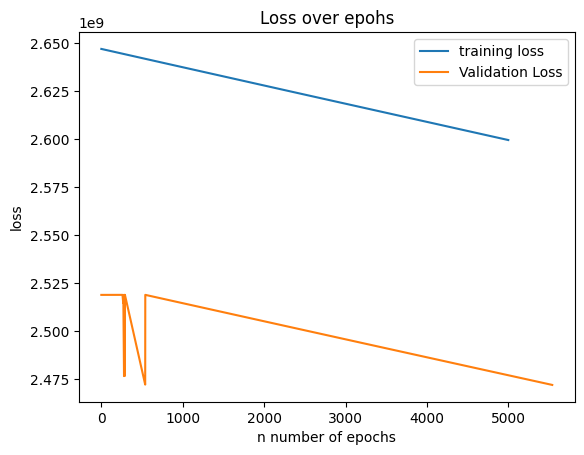

In [48]:
# 4. Plot the training and validation loss after each iteration
plt.plot(losses, label="training loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("n number of epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Loss over epohs")
plt.show()